# Problem 1

### Handle imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from google.colab.patches import cv2_imshow
import skimage
import sklearn

### Load MNIST Dataset

In [0]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# One-hot encode y_train and y_test
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

### Resize (No Interpolation) Util Function

In [0]:
def noInterResize(image, shape):
  return skimage.transform.resize(image, shape, mode='edge', anti_aliasing=False,
                                  anti_aliasing_sigma=None, preserve_range=True, order=0)

## Functions for extracting Hand-Crafted Features from Data

### Extract width of digit

In [0]:
def extractWidth(image, th=0.5):
  minX, maxX = 0, 28
  # Get the minimum margin boundary
  flag = False
  for x in range(len(image[0])):
    for y in range(len(image)):
      pixel = image[y][x]
      if pixel > th:
        flag = True
        minX = x
        break
    if flag:
      break
  # Get the maximum margin boundary
  flag = False
  for x in range(len(image[0])-1, -1, -1):
    for y in range(len(image)):
      pixel = image[y][x]
      if pixel > th:
        flag = True
        maxX = x
        break
    if flag:
      break
  # Return range of width
  return maxX - minX

### Extract height of digit

In [0]:
def extractHeight(image, th=0.5):
  minY, maxY = 0, 28
  # Get the minimum margin boundary
  flag = False
  for y in range(len(image)):
    for x in range(len(image[0])):
      pixel = image[y][x]
      if pixel > th:
        flag = True
        minY = y
        break
    if flag:
      break
  # Get the maximum margin boundary
  flag = False
  for x in range(len(image[0])):
    for y in range(len(image)-1, -1, -1):
      pixel = image[y][x]
      if pixel > th:
        flag = True
        maxY = y
        break
    if flag:
      break
  # Return range of height
  return maxY - minY

### Extract Pooling Features

In [0]:
def extractPoolingFeatures(image):
  features = np.zeros((4, 4), dtype='float')
  for x in range(4):
    for y in range(4):
      avg = np.average(image[y*7:y*7+7, x*7:x*7+7]) / 255.0
      features[y, x] = avg
  return features

def extractPoolingFeaturesFlattened(image):
  features = np.zeros((4, 4), dtype='float')
  for x in range(4):
    for y in range(4):
      avg = np.average(image[y*7:y*7+7, x*7:x*7+7]) / 255.0
      features[y, x] = avg
  return features.reshape((16,))

### Extract White Regions

In [0]:
def recursiveDepthFirstSearch(image, visited, y, x, th):
  if y >= 28 or y < 0 or x >= 28 or x < 0:
    return
  if visited[y, x] == 0 and image[y, x] < th:
    visited[y, x] = 1
    recursiveDepthFirstSearch(image, visited, y+1, x, th)
    recursiveDepthFirstSearch(image, visited, y-1, x, th)
    recursiveDepthFirstSearch(image, visited, y, x+1, th)
    recursiveDepthFirstSearch(image, visited, y, x-1, th)

def extractNumWhiteRegions(image, th=128):
  """
    Extract the number of white regions in the image where any pixel above the
    param th is considered white.
  """
  numWhiteRegions = 0
  visited = np.zeros(image.shape)
  for y in range(image.shape[0]):
    for x in range(image.shape[1]):
      if image[y, x] < th and visited[y, x] == 0:
        numWhiteRegions += 1
      recursiveDepthFirstSearch(image, visited, y, x, th)
  # One-Hot Encode number of white regions
  onehot = np.zeros((4,), dtype='float32')
  if numWhiteRegions == 1:
    onehot[0] = 1.0
  if numWhiteRegions == 2:
    onehot[1] = 1.0
  if numWhiteRegions == 3:
    onehot[2] = 1.0
  if numWhiteRegions >= 4:
    onehot[3] = 1.0
  return onehot
        

## Testing Feature Extraction on Images

### Testing Width Extraction

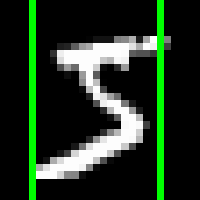

In [0]:
image = x_train[0]

th = 128
# Get minimum margin boundary
flag = False
for x in range(len(image[0])):
  for y in range(len(image)):
    pixel = image[y][x]
    if pixel > th:
      flag = True
      minX = x
      break
  if flag:
    break

# Get width via feature extraction function
width = extractWidth(image, th)

# Convert image to color
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw lines according to width
cv2.line(image, (minX, 0), (minX, 28), (0, 255, 0))
cv2.line(image, (minX+width, 0), (minX+width, 28), (0, 255, 0))

# Resize image so it is easier to see
image = noInterResize(image, (200, 200))

# Display image
cv2_imshow(image)

### Testing Height Extraction

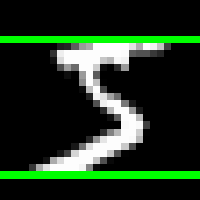

In [0]:
image = x_train[0]

th = 128
# Get minimum margin boundary
flag = False
for y in range(len(image)):
  for x in range(len(image[0])):
    pixel = image[y][x]
    if pixel > th:
      flag = True
      minY = y
      break
  if flag:
    break

# Get height via feature extraction function
height = extractHeight(image, th)

# Convert image to color
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw lines according to height
cv2.line(image, (0, minY), (28, minY), (0, 255, 0))
cv2.line(image, (0, minY+height), (28, minY+height), (0, 255, 0))

# Resize image so it is easier to see
image = noInterResize(image, (200, 200))

# Display image
cv2_imshow(image)

### Testing Pooling Feature Extraction

0


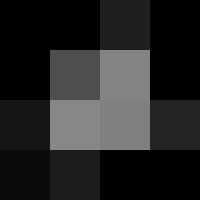

1


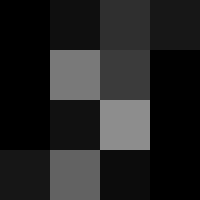

2


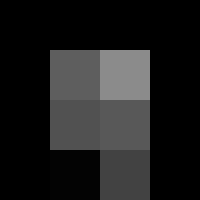

3


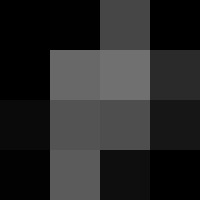

4


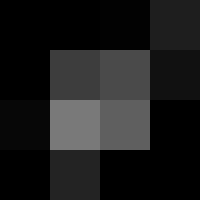

5


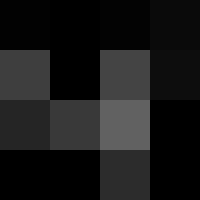

6


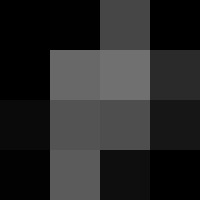

7


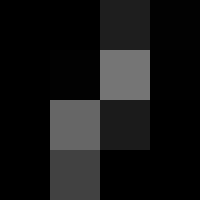

8


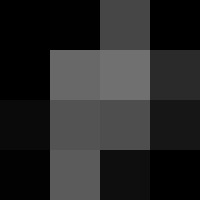

9


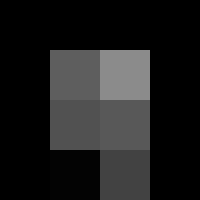

In [0]:
# Getting the averages of for all mnist digits for comparison of effectiveness

# Initialize averages
runningTotals = [np.zeros((4,4), dtype='float') for i in range(10)]

for digit in range(10):
  allDigits = x_train[np.where(y_train[digit] == 1)]
  for image in allDigits:
    poolingFeatures = extractPoolingFeatures(image)
    runningTotals[digit] = np.add(runningTotals[digit], poolingFeatures)
  runningTotals[digit] /= len(allDigits) / 255.0
  image = noInterResize(runningTotals[digit], (200, 200))
  print(digit)
  cv2_imshow(image)

### Testing Number of White Regions Extraction

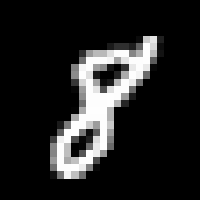

[0. 0. 1. 0.]


In [0]:
image = x_train[17]

# Resize image so it is easier to see
resizedImage = noInterResize(image, (200, 200))

# Display resized image
cv2_imshow(resizedImage)

th = 128
numOfWhiteRegions = extractNumWhiteRegions(image, th)
print(numOfWhiteRegions)

## Build a Keras Model

In [0]:
INPUT_SHAPE = (22,)

model = keras.models.Sequential()
model.add(keras.layers.Dense(10, activation='softmax', input_shape=INPUT_SHAPE))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Process Training Data, Gathering Hand-Crafted Features in New x_train Array

In [0]:
new_x_train = []

i = 0
for x in x_train:
  width = np.array([extractWidth(x)]).reshape(1,)
  height = np.array([extractHeight(x)]).reshape(1,)
  poolingFeatures = extractPoolingFeatures(x).reshape((16,))
  numWhiteRegions = np.array([extractNumWhiteRegions(x)]).reshape(4,)
  vecX = np.concatenate((width, height, poolingFeatures, numWhiteRegions))
  new_x_train.append(vecX)
  i += 1

  if i % 10000 == 0:
    print(i)

print('Done')

10000
20000
30000
40000
50000
60000
Done


## Process Testing Data, Gathering Hand-Crafted Features in New x_test Array

In [0]:
new_x_test = []

i = 0
for x in x_test:
  width = np.array([extractWidth(x)]).reshape(1,)
  height = np.array([extractHeight(x)]).reshape(1,)
  poolingFeatures = extractPoolingFeatures(x).reshape((16,))
  numWhiteRegions = np.array([extractNumWhiteRegions(x)]).reshape(4,)
  vecX = np.concatenate((width, height, poolingFeatures, numWhiteRegions))
  new_x_test.append(vecX)
  i += 1
  
  if i % 1000 == 0:
    print(i)

print('Done')

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Done


## Fit Model and Evaluate Score

In [0]:
new_x_train = np.asarray(new_x_train)
new_x_test = np.asarray(new_x_test)

EPOCHS = 50

print(new_x_train.shape)

history = model.fit(new_x_train, y_train, batch_size=128, epochs=EPOCHS, verbose=1, validation_split=0.2)

(60000, 22)



Train on 48000 samples, validate on 12000 samples
Epoch 1/50





48000/48000 [==============================] - 1s 25us/step - loss: 0.0976 - acc: 0.2142 - val_loss: 0.0780 - val_acc: 0.3725
Epoch 2/50
48000/48000 [==============================] - 1s 11us/step - loss: 0.0722 - acc: 0.4689 - val_loss: 0.0674 - val_acc: 0.5309
Epoch 3/50
48000/48000 [==============================] - 0s 10us/step - loss: 0.0647 - acc: 0.5516 - val_loss: 0.0610 - val_acc: 0.6082
Epoch 4/50
48000/48000 [==============================] - 1s 11us/step - loss: 0.0593 - acc: 0.6178 - val_loss: 0.0563 - val_acc: 0.6472
Epoch 5/50
48000/48000 [==============================] - 1s 11us/step - loss: 0.0551 - acc: 0.6525 - val_loss: 0.0526 - val_acc: 0.6869
Epoch 6/50
48000/48000 [==============================] - 1s 11us/step - loss: 0.0517 - acc: 0.6787 - val_loss: 0.0492 - val_acc: 0.7116
Epoch 7/50
48000/48000 [==============================] - 1s 11us/step - loss: 0.0489 - acc: 0.6989 - val_lo

In [0]:
metrics = model.evaluate(new_x_test, y_test)
print('Test Loss:', metrics[0])
print('Test Accuracy:', metrics[1])

10000/10000 [==============================] - 0s 18us/step
Test Loss: 0.027824163883924485
Test Accuracy: 0.8127


In [0]:
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
epochs_range = range(1, EPOCHS+1)

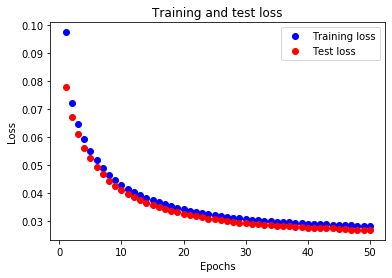

In [0]:
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

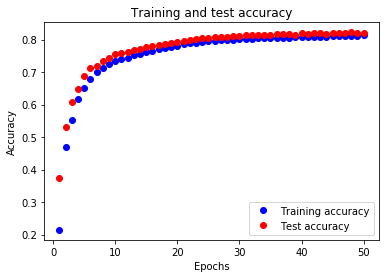

In [0]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']
plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As the graphs show, the network seems to be nearing its peak performance with its current features and settings. 81% accuracy on the testing dataset isn't too bad for only a single layer network with hand-crafted features. Certainly, we could find better features to raise the performance even higher though.

One important thing to note is that the network does not seem to be overfitting at all. The gap between the training and testing scores is very, very small.